In [1]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import LineString, Point
import contextily as ctx

In [2]:
gdf_ulice = gpd.read_file('data/Streets_Krakow.shp')
gdf_zabki = gpd.read_file('data/Zabki_Krakow.geojson')
gdf_nearest_points = gpd.read_file('data/Nearest_points.geojson')
gdf_ulice.to_crs(epsg=4326, inplace=True)
gdf_zabki.to_crs(epsg=4326, inplace=True)
gdf_nearest_points.to_crs(epsg=4326, inplace=True)

best_path = np.load('data/best_route.npy')
distance_matrix = np.load('data/distance_matrix.npy')
path_matrix = np.load('data/path_matrix.npy', allow_pickle=True)

distance = 0
for i in range(len(best_path)-1):
    distance += distance_matrix[best_path[i], best_path[i+1]]
print('Total distance:', round(distance/1000, 3), 'km')

Total distance: 391.072 km


In [3]:
pairs = pd.DataFrame({
    'from_idx': best_path[:-1],
    'to_idx': best_path[1:]
})

lines = [path_matrix[from_idx, to_idx] for from_idx, to_idx in zip(pairs['from_idx'], pairs['to_idx'])]

line_geometries = [LineString(line) for line in lines]

gdf_lines = gpd.GeoDataFrame(geometry=line_geometries)
gdf_lines.crs = gdf_ulice.crs
gdf_lines

,geometry
0,"LINESTRING (19.81967 50.03508, 19.82045 50.035..."
1,"LINESTRING (19.84875 50.08566, 19.8488 50.0855..."
2,"LINESTRING (19.88219 50.08157, 19.88235 50.081..."
3,"LINESTRING (19.88289 50.08228, 19.88289 50.082..."
4,"LINESTRING (19.88859 50.08146, 19.8888 50.0814..."
...,...
500,"LINESTRING (19.91324 50.0973, 19.91315 50.0973..."
501,"LINESTRING (19.90268 50.09201, 19.90282 50.091..."
502,"LINESTRING (19.89574 50.08576, 19.8953 50.0858..."
503,"LINESTRING (19.89164 50.08876, 19.89175 50.088..."


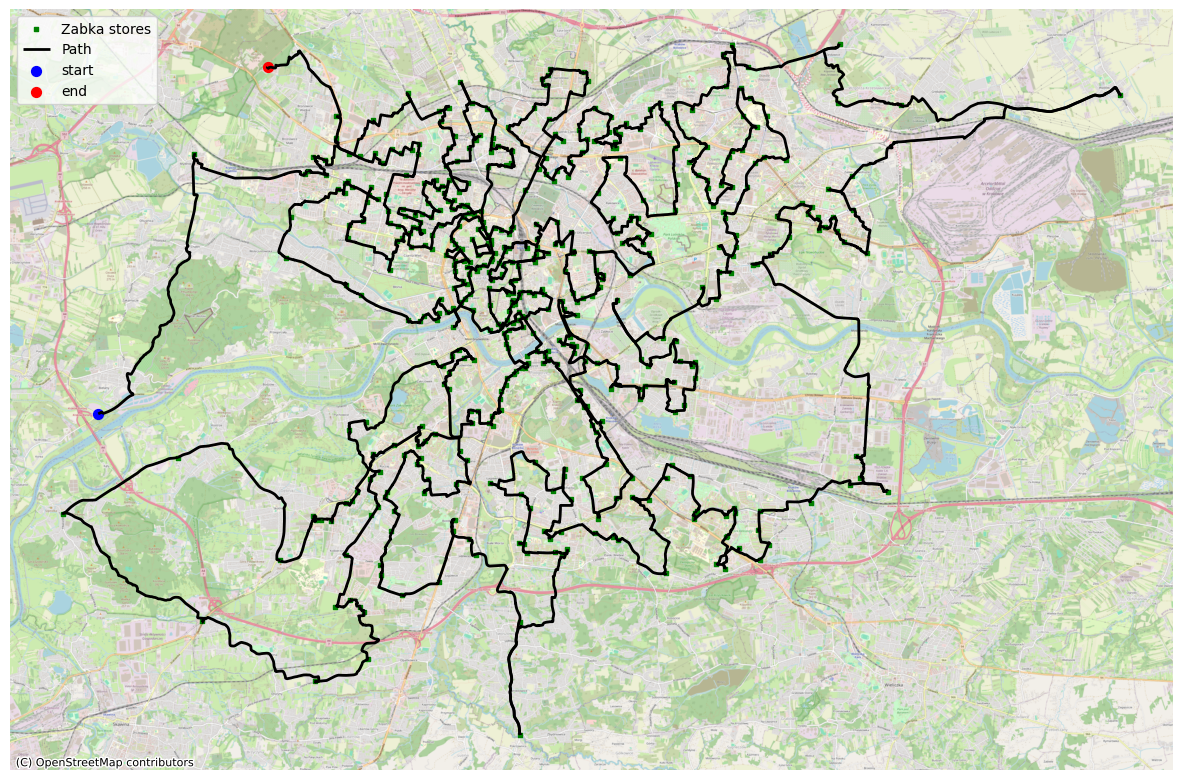

In [5]:
gdf_zabki = gdf_zabki.to_crs(epsg=3857)
gdf_lines = gdf_lines.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(15, 15))
gdf_zabki.plot(ax=ax, color='green', markersize=12, marker='s', label='Zabka stores')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=14)
gdf_lines.plot(ax=ax, color='black', linewidth=2, label='Path')
first_point = gdf_lines.iloc[0].geometry.coords[0]
last_point = gdf_lines.iloc[-1].geometry.coords[-1]
points_gdf = gpd.GeoDataFrame(
    geometry=[Point(first_point), Point(last_point)],
    crs=gdf_lines.crs
)
points_gdf.head(1).plot(ax=ax, color='blue', markersize=50, label='start')
points_gdf.tail(1).plot(ax=ax, color='red', markersize=50, label='end')
plt.legend()

ax.set_axis_off()
plt.show()

In [11]:
import imageio
import os
from tqdm.notebook import tqdm

first_point = gdf_lines.iloc[0].geometry.coords[0]
last_point = gdf_lines.iloc[-1].geometry.coords[-1]

points_gdf = gpd.GeoDataFrame(
    geometry=[Point(first_point), Point(last_point)],
    crs=gdf_lines.crs
)

frames = []
output_dir = "frames/"
os.makedirs(output_dir, exist_ok=True)

for i in tqdm(range(len(gdf_lines)), desc='Generating frames'):
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf_zabki.plot(ax=ax, color='green', markersize=12, marker='s', label='Zabka stores')
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=14)
    
    gdf_lines.iloc[:i+1].plot(ax=ax, color='black', linewidth=2, label='Path')
    
    plt.tight_layout()
    plt.legend()
    ax.set_axis_off()
    
    frame_path = f"{output_dir}frame_{i:03d}.png"
    plt.savefig(frame_path, bbox_inches='tight', pad_inches=0.1)
    plt.close(fig)
    frames.append(frame_path)

# Create GIF
gif_path = "best_path_animation.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.5) as writer:
    for frame in frames:
        image = imageio.imread(frame)
        writer.append_data(image)

print(f"GIF saved at {gif_path}")

Generating frames:   0%|          | 0/505 [00:00<?, ?it/s]

C:\Users\bugaj\AppData\Local\Temp\ipykernel_1412\3966364457.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame)


GIF saved at best_path_animation.gif
